# Generate datasets for I1 section regression

- images, dimensions, area


In [30]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import path
import pandas as pd
import os
import pickle
from sklearn.preprocessing import MinMaxScaler

import cv2
from sections import section, VERTEX_FUNCTIONS
import utils
from poly import integrate00

import importlib
importlib.reload(utils)

<module 'utils' from '/home/pagzal/projects/shape_cv_2d/utils.py'>

## get the generating functions

In [31]:
func, parameter_names = VERTEX_FUNCTIONS['i1']
print(parameter_names)

['h', 'tw', 'ba', 'ta', 'bf', 'tf']


## data generated by minizinc

- show distribution, 
- filter them: most of them are too thick.
- should tweak the minizinc script to get more typical examples

In [32]:
df = pd.read_csv("minizinc_profiles/i1.csv")
print(len(df))
df.head() #query("tw == 1")

6565


,h,tw,bf,tf,ba,ta
0,17,1,2,1,2,1
1,17,1,2,1,3,1
2,17,1,3,1,3,1
3,17,1,2,1,4,1
4,17,1,3,1,4,1


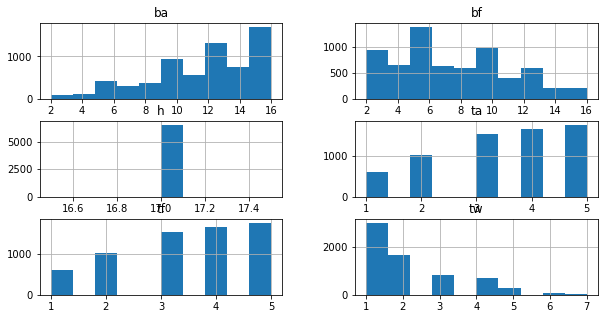

In [6]:
#dff = df[(df.tw < 6)]
dff = df.copy()
dff.hist(layout=(3,2), figsize=(10,5));

In [7]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6565 entries, 0 to 6564
Data columns (total 6 columns):
h     6565 non-null int64
tw    6565 non-null int64
bf    6565 non-null int64
tf    6565 non-null int64
ba    6565 non-null int64
ta    6565 non-null int64
dtypes: int64(6)
memory usage: 307.9 KB


[17  3 16  4 11  3]


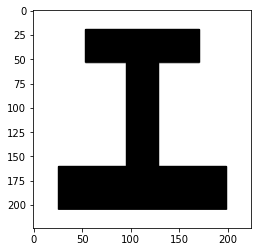

In [13]:
params = dff[parameter_names].sample().values.flatten()
print(params)
outers, inners = func(*params)
img = utils.image_cv2(outers, inners, figsize=224, pad=20)
#cv2.imwrite("/home/pagzal/tmp/c_cv2.png", img) # RGB
plt.imshow(img, aspect='equal', );

## compute area

In [14]:
# TODO: move into poly
def polygon_area(outers, inners):
    area = 0
    for vertices in outers:
        area += abs(integrate00(vertices))
    for vertices in inners:
        area -= abs(integrate00(vertices))
    return area


def compute_area(row):
    params = [row[p] for p in parameter_names]
    #print(params)
    outers, inners = func(*params)
    area = polygon_area(outers, inners)
    return area
    
dff['area'] = dff.apply(compute_area, axis=1)

# make dimensionless params by deviding by sqrt(A)
sqrta = dff.area.apply(np.sqrt)

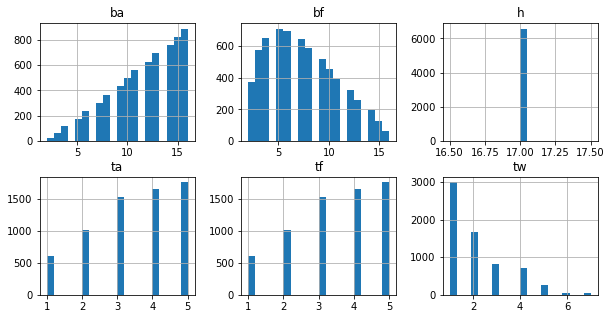

In [15]:
# are these data biased? should I re-sample the training data???
dff[parameter_names].hist(bins=20, layout=(2,3), figsize=(10,5));

## make train/val/test split

In [16]:
pct_val = .15
pct_test = .15

n = len(dff)
n_val = int(n*pct_val)
n_test = int(n*pct_test)
n_train = n - n_val - n_test
#print(n, n_train, n_val, n_test)

In [17]:
indices = np.arange(n)
np.random.seed(0)
np.random.shuffle(indices, )

indices_train = indices[:n_train]
indices_val = indices[n_train:n_train+n_val]
indices_test = indices[n_train+n_val:]

dataframes = {
    "train": dff.loc[indices_train], #.reset_index(drop=True),
    "val": dff.loc[indices_val], #.reset_index(drop=True),
    "test": dff.loc[indices_test] #.reset_index(drop=True)
}

for key, df_ in dataframes.items():
    print(key, len(df_))

train 4597
val 984
test 984


In [18]:
dataframes['train']

,h,tw,bf,tf,ba,ta,area
3060,17,3,8,5,16,3,115.0
6195,17,2,7,5,14,5,119.0
4037,17,2,6,4,10,4,82.0
3029,17,3,10,5,13,3,116.0
878,17,1,4,3,10,2,44.0
...,...,...,...,...,...,...,...
4253,17,4,11,4,14,4,136.0
2005,17,1,6,3,10,3,59.0
1959,17,2,11,2,16,3,94.0
6280,17,3,9,5,13,5,131.0


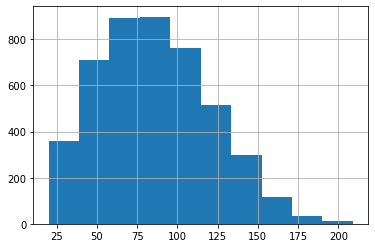

In [19]:
dataframes['train'].area.hist();

## max/min scaling for regression target, based on train data

In [20]:
df_train = dataframes['train']
train_data = df_train[parameter_names].values #
area = df_train['area'].values.reshape(-1,1)
scaled1 = train_data / np.sqrt(area)

In [21]:
scaler = MinMaxScaler().fit(scaled1)

In [22]:
scaled_parameter_names = [s+"_scaled" for s in parameter_names]
for key in dataframes:
    df_ = dataframes[key].copy()
    data = df_[parameter_names].values
    sqrt_area = np.sqrt(df_['area'].values).reshape(-1,1)
    scaled = scaler.transform(data/sqrt_area)
    scaled_df = pd.DataFrame(scaled, columns=scaled_parameter_names, index=df_.index)
    df_new = pd.concat([df_, scaled_df], axis=1)
    dataframes[key] = df_new

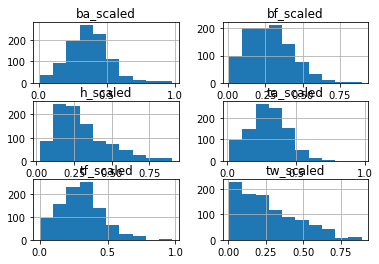

In [23]:
dataframes['val'].filter(regex="_scaled").hist();

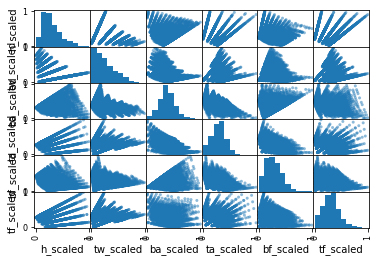

In [24]:
pd.plotting.scatter_matrix(dataframes['train'].filter(regex="_scaled"));

## create and save images, save metadata

In [25]:
# clean data dir
!rm -r dataset/train/I1/*
!rm -r dataset/val/I1/*
!rm -r dataset/test/I1/*
!rm dataset/I1_*

rm: cannot remove 'dataset/train/I1/*': No such file or directory
rm: cannot remove 'dataset/val/I1/*': No such file or directory
rm: cannot remove 'dataset/test/I1/*': No such file or directory
rm: cannot remove 'dataset/I1_*': No such file or directory


In [26]:
basedir = "dataset"

image_dirs = {
    "train": os.path.join(basedir, "train", "I1"),
    "val": os.path.join(basedir, "val", "I1"),
    "test": os.path.join(basedir, "test", "I1")
}

if not os.path.exists(basedir):
    os.mkdir(basedir)
    
for phase in image_dirs:
    dirname = os.path.join(basedir, phase)
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    
for dirname in image_dirs.values():
    if not os.path.exists(dirname):
        os.mkdir(dirname)

In [27]:
FIGSIZE = 224
PAD = 20

for phase, df_phase in dataframes.items():
    filenames = []
    for tup in df_phase.itertuples():
        params = [getattr(tup, p) for p in parameter_names]
        outers, inners = func(*params)    
        img = utils.image_cv2(outers, inners, figsize=FIGSIZE, pad=PAD)
        filename = os.path.join(image_dirs[phase], "%g.png"%tup.Index)
        cv2.imwrite(filename, img) # RGB
        relpath = os.path.relpath(filename, image_dirs[phase])
        filenames.append(relpath)
    df_phase['filename'] = filenames

In [28]:
with open("dataset/I1_scaler.pkl", "wb", ) as fp:
    pickle.dump(scaler, fp)

In [29]:
for phase, df_phase in dataframes.items():
    filename = "I1_%s.csv" % phase
    df_phase.to_csv(os.path.join(basedir, filename), index=False, index_label='id')